In [1]:
import pandas as pd
import numpy as np

In [2]:
with open('../data/continents2.csv') as f:
  regions = pd.read_csv(f)
  print(regions['sub-region'].unique())

['Southern Asia' 'Northern Europe' 'Southern Europe' 'Northern Africa'
 'Polynesia' 'Sub-Saharan Africa' 'Latin America and the Caribbean' nan
 'Western Asia' 'Australia and New Zealand' 'Western Europe'
 'Eastern Europe' 'Northern America' 'South-eastern Asia' 'Eastern Asia'
 'Melanesia' 'Micronesia' 'Central Asia']


In [3]:
def clusterByRegion(Data, MeanAggregation=True):
  """
    Clusters the Dataset by region applying the sub regions found in the continents2 dataset

    Parameters:
        x (pd.DataFrame) the dataset to be grouped
        MeanAggregation (boolean) if true, takes the mean of Data's Features, if false, takes the sum of the features

    Returns:
        grouped (pd.DataFrame) a grouped dataframe
    """
  regions = pd.read_csv("../data/continents2.csv")
  regions = regions[['alpha-3', 'sub-region']]

  merge = Data.merge(regions, how = "left", left_on = 'country_code', right_on ='alpha-3' )
  merge.drop(['country_code', 'country_name', "alpha-3"], axis=1, inplace=True)

  if MeanAggregation:
    grouped = merge.groupby(['sub-region', 'year'], as_index=False).agg('mean')
  else:
    grouped = merge.groupby(['sub-region', 'year'],as_index=False).agg('sum')

  return grouped


In [4]:
data = pd.read_csv('../data/methane_emissions.csv')
df = clusterByRegion(data, False)
print(df)

                    sub-region  year  \
0    Australia and New Zealand  1990   
1    Australia and New Zealand  1991   
2    Australia and New Zealand  1992   
3    Australia and New Zealand  1993   
4    Australia and New Zealand  1994   
..                         ...   ...   
488             Western Europe  2014   
489             Western Europe  2015   
490             Western Europe  2016   
491             Western Europe  2017   
492             Western Europe  2018   

                                                sector   value  
0    Total excluding LUCFTotal including LUCFEnergy...  605.12  
1    Total excluding LUCFTotal including LUCFEnergy...  603.01  
2    Total excluding LUCFTotal including LUCFEnergy...  602.32  
3    Total excluding LUCFTotal including LUCFEnergy...  590.70  
4    Total excluding LUCFTotal including LUCFEnergy...  587.83  
..                                                 ...     ...  
488  Total excluding LUCFTotal including LUCFEnergy...  495.29  

Group the data by `sub-region`, sort each group by year, compute the anomaly using the LLR function, run permutation testing, filter for significant anomalies (p-value < 0.05), and finally sort the results by LLR in descending order.

In [5]:
def compute_llr(x):
    """
    Compute the maximum log-likelihood ratio (LLR) for a change point in a 1D array x.
    Returns the best LLR score, the index of the best change point, and the anomalous subset S*.

    Parameters:
        x (np.array): Array of numeric data.

    Returns:
        best_llr (float): Maximum improvement in fit (LLR score).
        best_t (int): Index of the best change point.
        best_subset (np.array): The anomalous subset, i.e. x[:best_t].
    """
    n = len(x)
    if n < 2:
        return None, None, None

    mean_all = np.mean(x)
    sse_all = np.sum((x - mean_all) ** 2)

    best_llr = -np.inf
    best_t = None
    best_subset = None

    for t in range(1, n):
        seg1 = x[:t]
        seg2 = x[t:]
        mean1 = np.mean(seg1)
        mean2 = np.mean(seg2)
        sse1 = np.sum((seg1 - mean1) ** 2)
        sse2 = np.sum((seg2 - mean2) ** 2)
        sse_split = sse1 + sse2
        llr = sse_all - sse_split
        if llr > best_llr:
            best_llr = llr
            best_t = t
            best_subset = x[:t]

    return best_llr, best_t, best_subset

In [6]:
results = {}

# Process the data on a per-region basis using 'sub-region'
for region, group in df.groupby('sub-region'):
    group_sorted = group.sort_values('year') # Sort by year
    emissions = group_sorted['value'].values # Extract emissions values
    if len(emissions) < 2: # Skip if not enough data points
        continue

    observed_llr, best_index, anomalous_subset = compute_llr(emissions) # Compute LLR

    # Extract all years corresponding to the anomalous subset
    anomalous_years = group_sorted['year'].iloc[:best_index].tolist()
    best_year = group_sorted.iloc[best_index]['year'] # Year of the most significant change point

    # Perform permutation testing to compute p-value
    num_permutations = 1000
    llr_permutations = np.zeros(num_permutations)
    for i in range(num_permutations):
        emissions_perm = np.random.permutation(emissions) # Randomly permute emissions
        llr_perm, _, _ = compute_llr(emissions_perm) # Compute LLR for permuted data

        # Handle cases where LLR is None
        llr_permutations[i] = llr_perm if llr_perm is not None else -np.inf 

    # Calculate p-value as the proportion of permuted LLRs greater than or equal to observed LLR
    p_value = np.mean(llr_permutations >= observed_llr)

    # Store results
    results[region] = {
        'observed_llr': observed_llr, # Observed LLR score
        'best_change_point_index': best_index, # Index of the most significant change point
        'best_year': best_year, # Year of the most significant change point
        'anomalous_years': anomalous_years, # Years corresponding to the anomalous subset
        'p_value': p_value, # p-value from permutation testing
        'n_points': len(emissions)  # Number of data points in the region
    }

# Filter and sort results: only include countries with a p-value < 0.05. These are the countries
# that show significant changes in emissions over time.
filtered_sorted_results = sorted(
    [(country, res) for country, res in results.items() if res['p_value'] < 0.05],
    key=lambda item: item[1]['observed_llr'], reverse=True) # Sort by observed LLR.
    # We want to regions with the most significant changes first.
    # Note: You can also sort by p-value if we want to prioritize regions with the lowest p-values.)

# Display the filtered and sorted results per region
for region, res in filtered_sorted_results:
    print(f"\nRegion: {region}")
    print(f"  Observed LLR: {res['observed_llr']}")
    print(f"  Best Change Point Index: {res['best_change_point_index']} (Year: {res['best_year']})")
    print(f"  Anomalous Years: {res['anomalous_years']}")
    print(f"  p-value from permutation testing: {res['p_value']}")
    print(f"  Number of Data Points: {res['n_points']}")


Region: Eastern Asia
  Observed LLR: 12781146.79631305
  Best Change Point Index: 19 (Year: 2009)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]
  p-value from permutation testing: 0.0
  Number of Data Points: 29

Region: Southern Asia
  Observed LLR: 4951264.923204261
  Best Change Point Index: 16 (Year: 2006)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005]
  p-value from permutation testing: 0.0
  Number of Data Points: 29

Region: Sub-Saharan Africa
  Observed LLR: 4110961.677657623
  Best Change Point Index: 17 (Year: 2007)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006]
  p-value from permutation testing: 0.0
  Number of Data Points: 29

Region: Eastern Europe
  Observed LLR: 2050780.0560672418
  Best Change Point Index: 3 (Year: 1993)
  Anomalous Years: 

# Graphing Change Point Anomalies
## Emissions

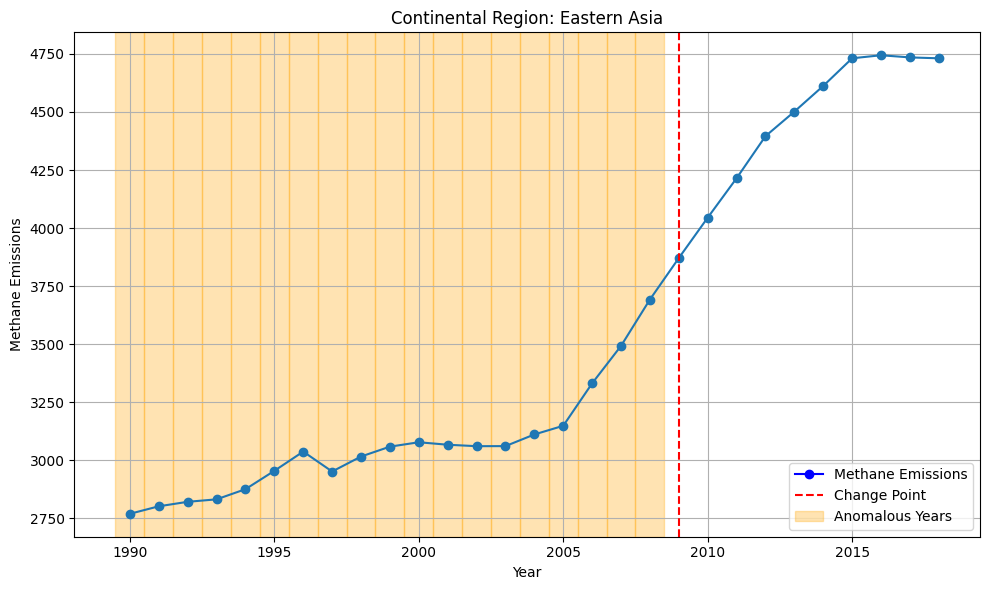

Region: Eastern Asia
  Observed LLR: 12781146.79631305
  Best Change Point Index: 19 (Year: 2009)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


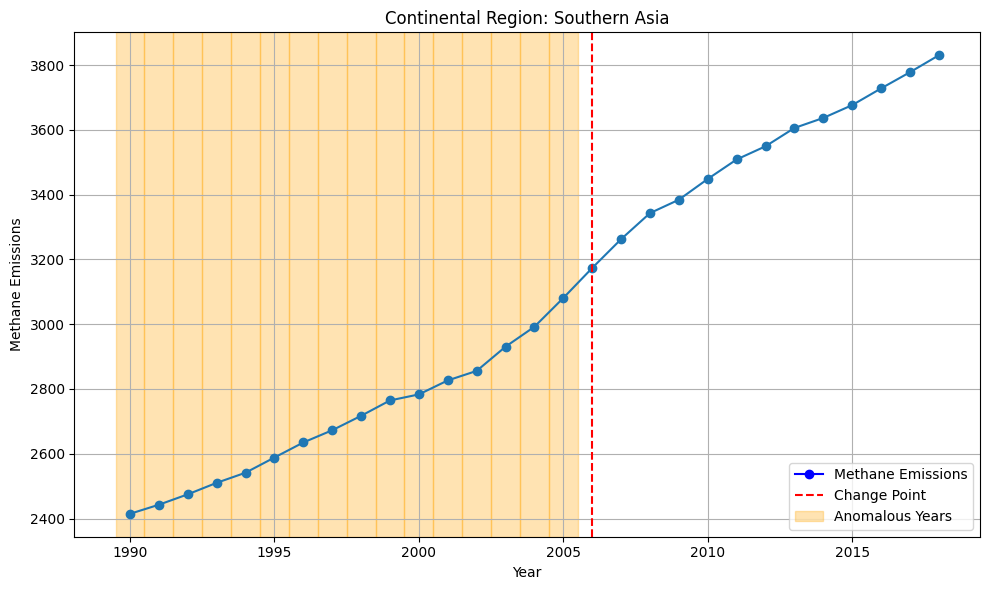

Region: Southern Asia
  Observed LLR: 4951264.923204261
  Best Change Point Index: 16 (Year: 2006)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


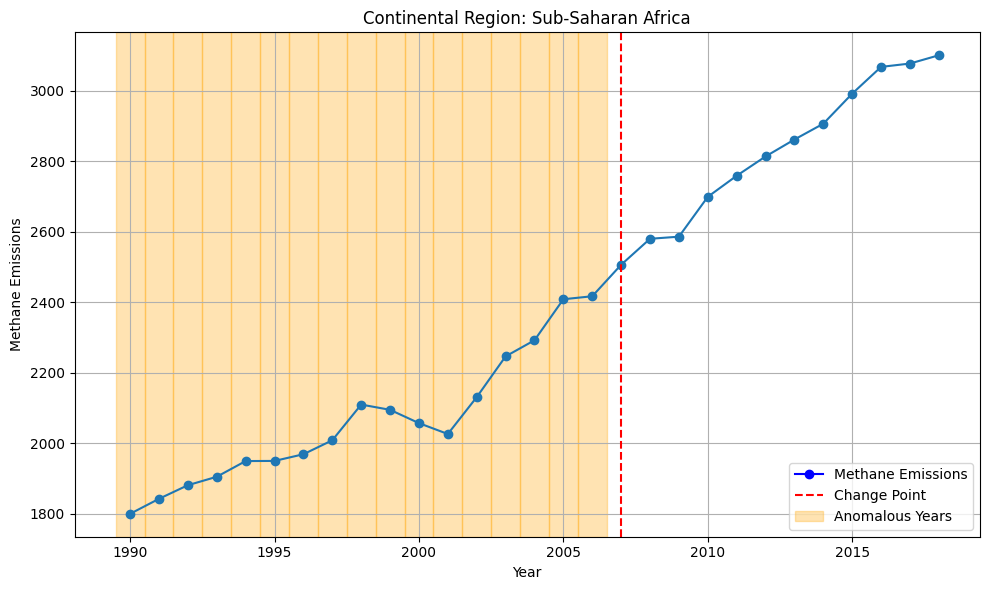

Region: Sub-Saharan Africa
  Observed LLR: 4110961.677657623
  Best Change Point Index: 17 (Year: 2007)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


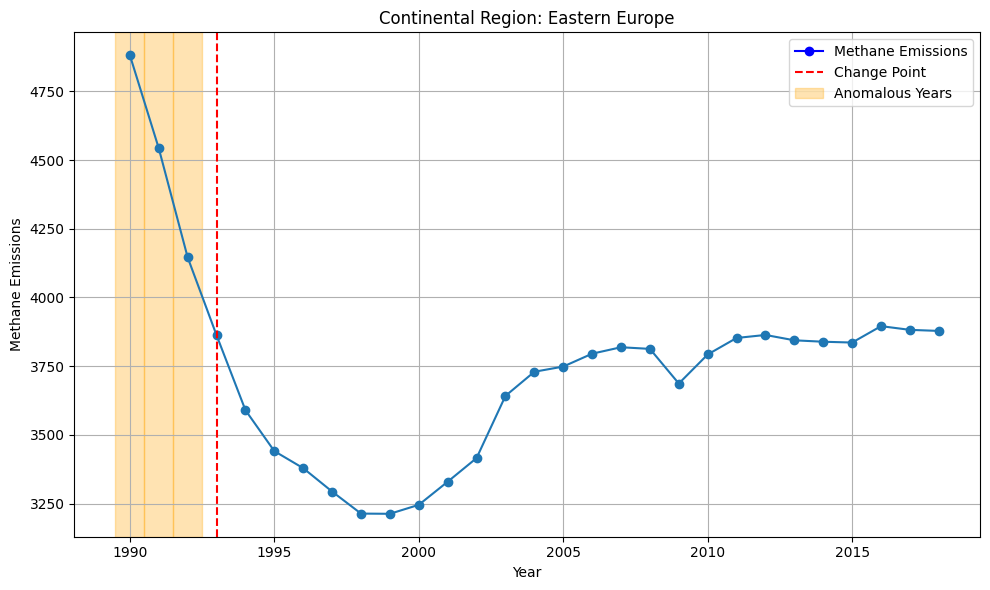

Region: Eastern Europe
  Observed LLR: 2050780.0560672418
  Best Change Point Index: 3 (Year: 1993)
  Anomalous Years: [1990, 1991, 1992]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


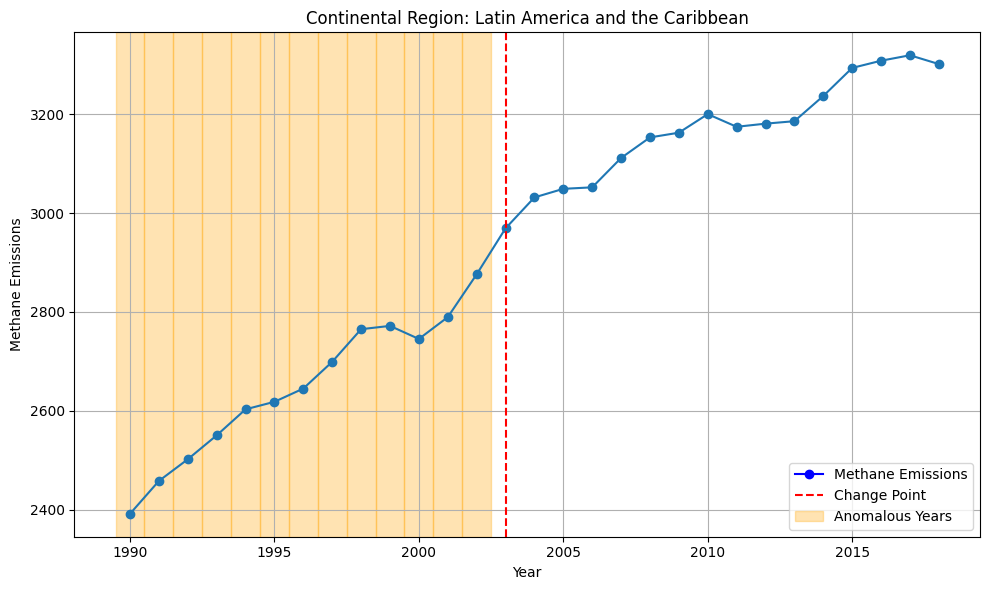

Region: Latin America and the Caribbean
  Observed LLR: 1965230.5720129968
  Best Change Point Index: 13 (Year: 2003)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


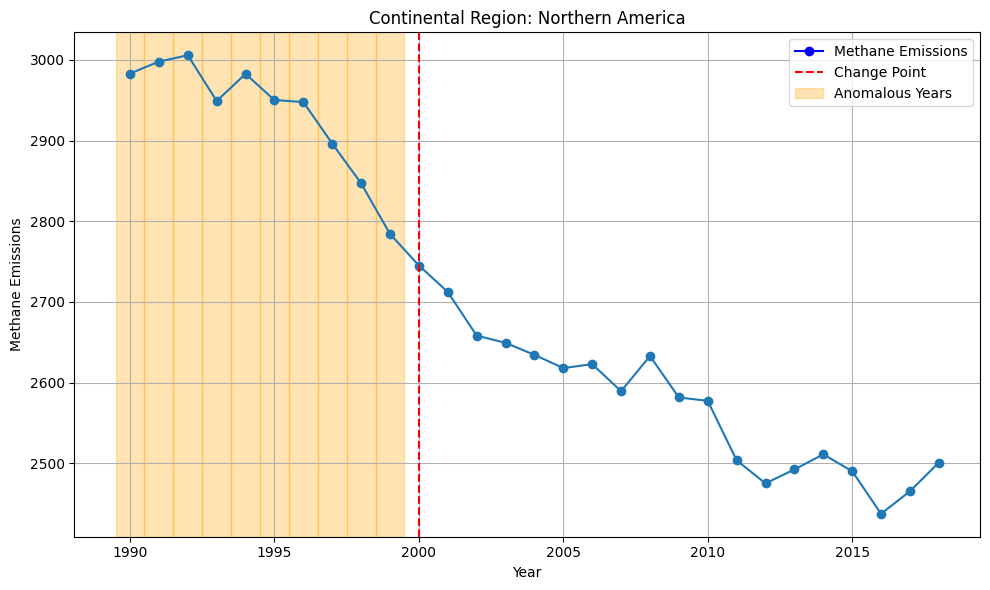

Region: Northern America
  Observed LLR: 853335.3563806894
  Best Change Point Index: 10 (Year: 2000)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


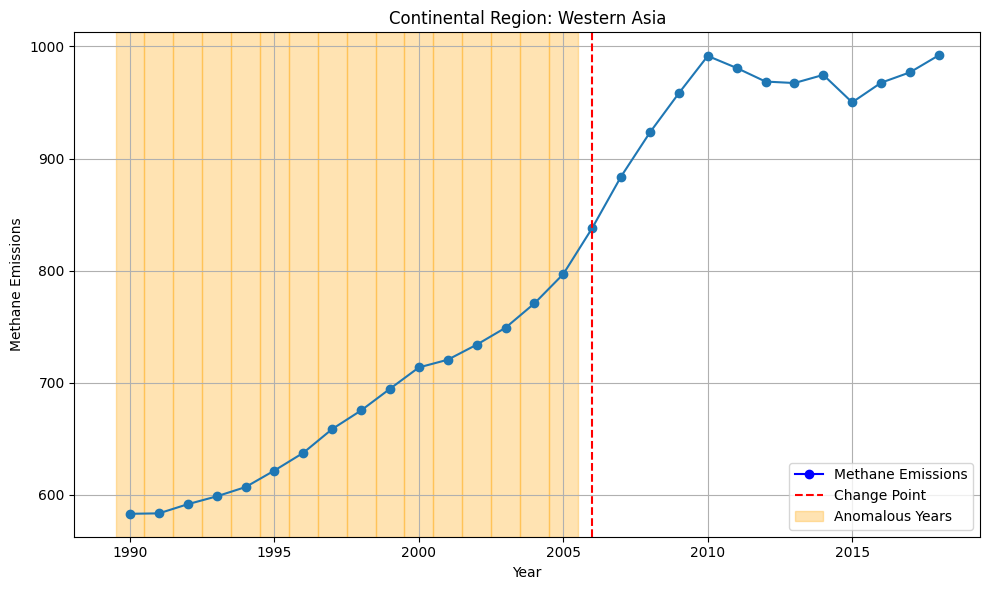

Region: Western Asia
  Observed LLR: 565655.9203862069
  Best Change Point Index: 16 (Year: 2006)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


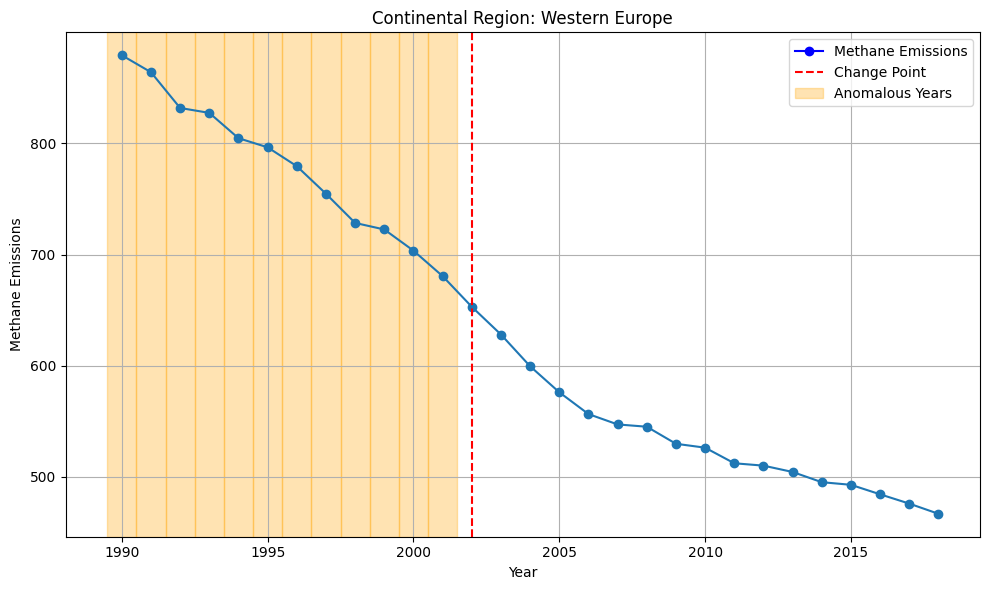

Region: Western Europe
  Observed LLR: 423836.9669945233
  Best Change Point Index: 12 (Year: 2002)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


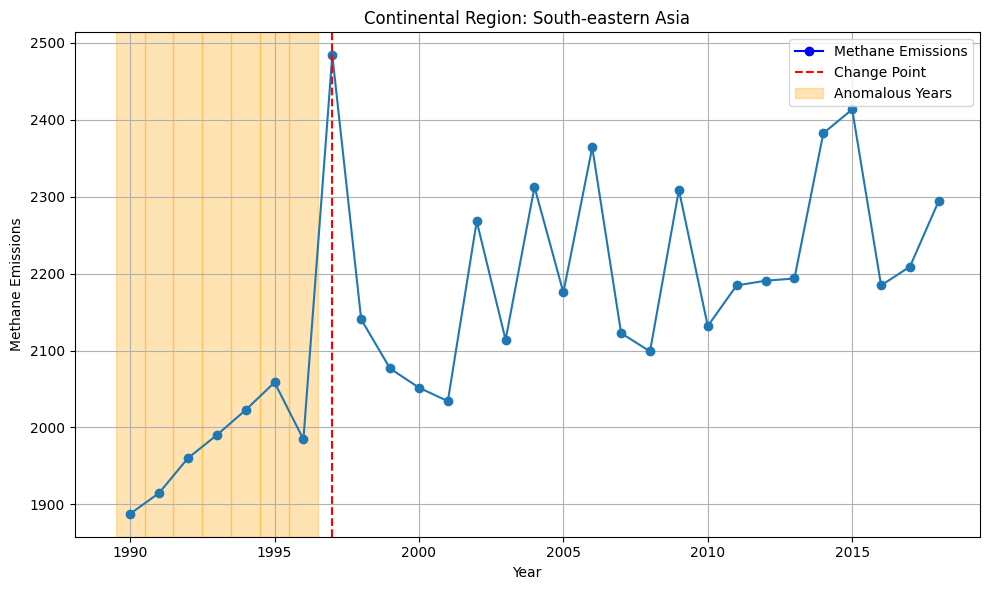

Region: South-eastern Asia
  Observed LLR: 308870.5771249664
  Best Change Point Index: 7 (Year: 1997)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996]
  p-value from permutation testing: 0.001
  Number of Data Points: 29
------------------------------------------------------------


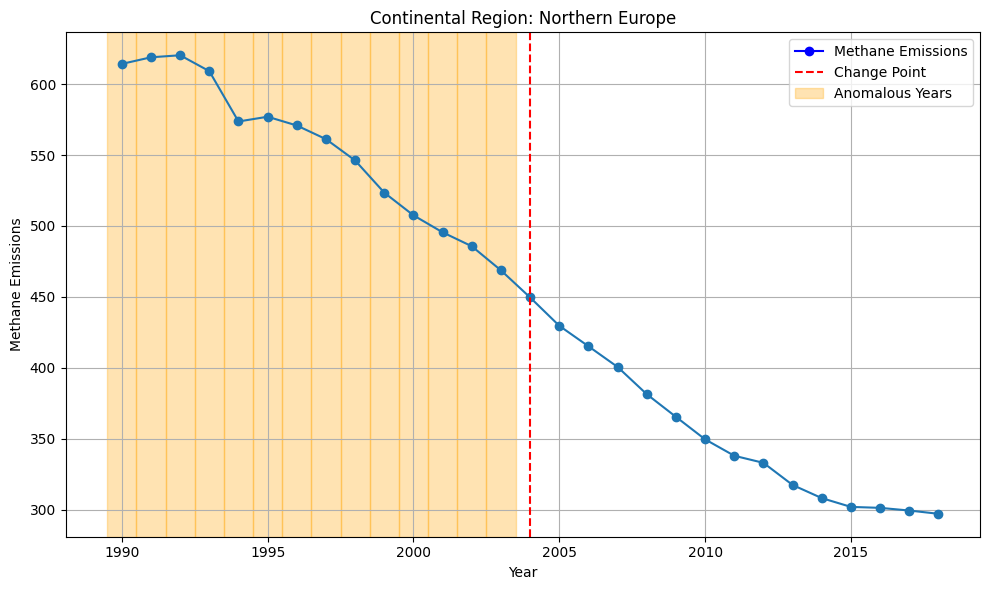

Region: Northern Europe
  Observed LLR: 297706.3552847455
  Best Change Point Index: 14 (Year: 2004)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


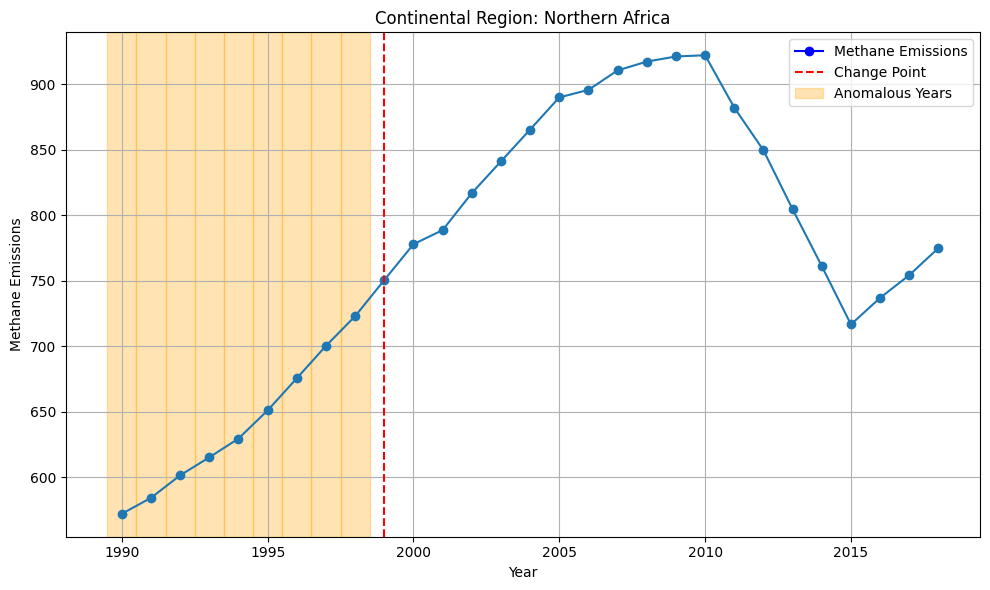

Region: Northern Africa
  Observed LLR: 223213.86565180076
  Best Change Point Index: 9 (Year: 1999)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


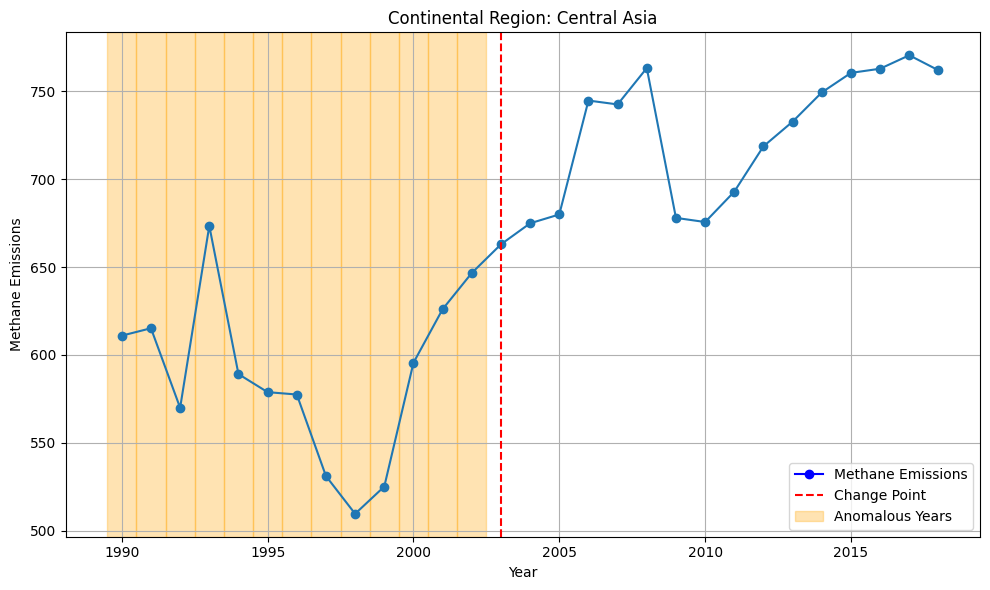

Region: Central Asia
  Observed LLR: 130419.5731034648
  Best Change Point Index: 13 (Year: 2003)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


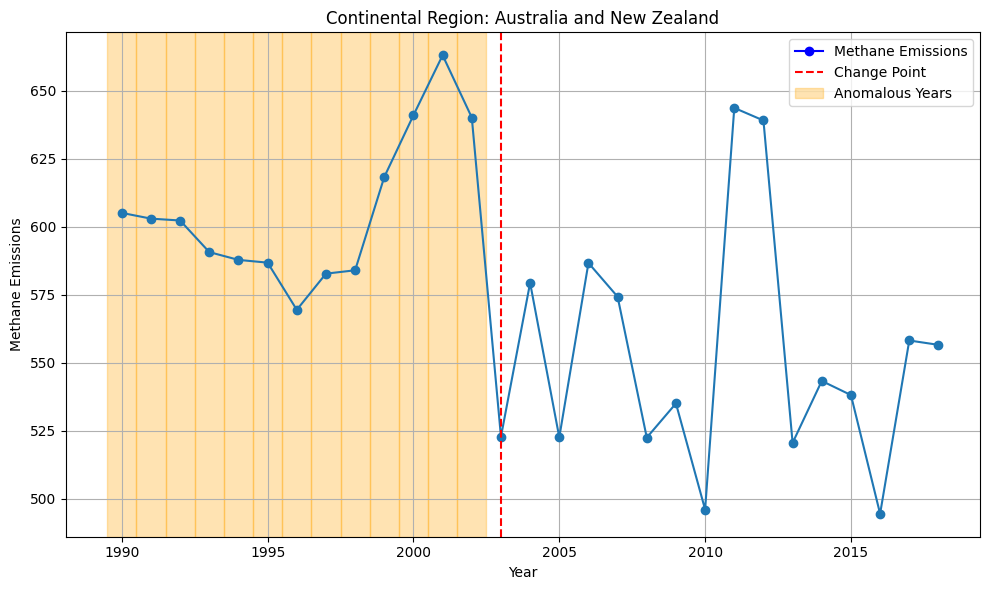

Region: Australia and New Zealand
  Observed LLR: 20665.8004811837
  Best Change Point Index: 13 (Year: 2003)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002]
  p-value from permutation testing: 0.008
  Number of Data Points: 29
------------------------------------------------------------


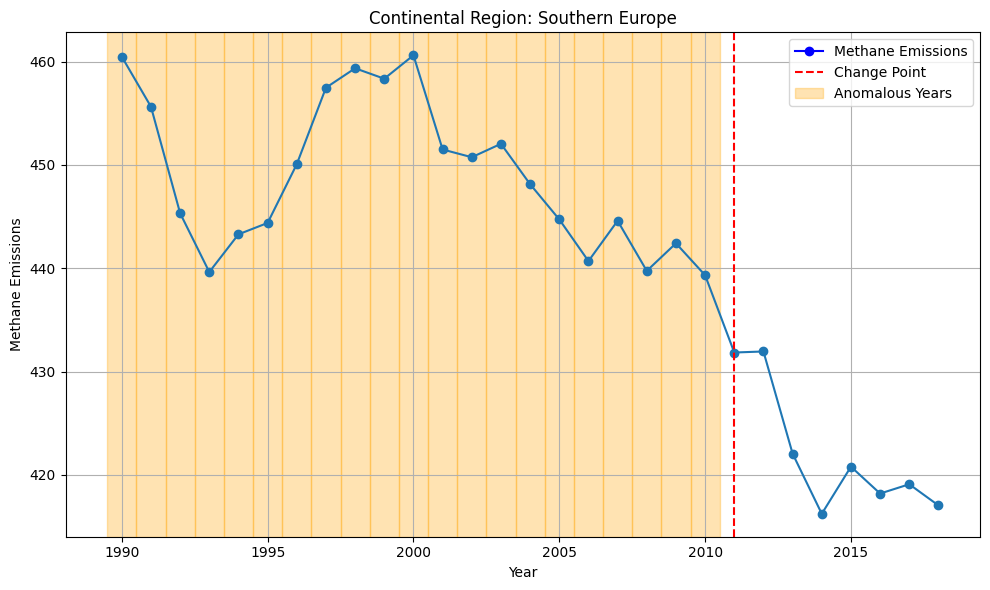

Region: Southern Europe
  Observed LLR: 4168.956507409688
  Best Change Point Index: 21 (Year: 2011)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


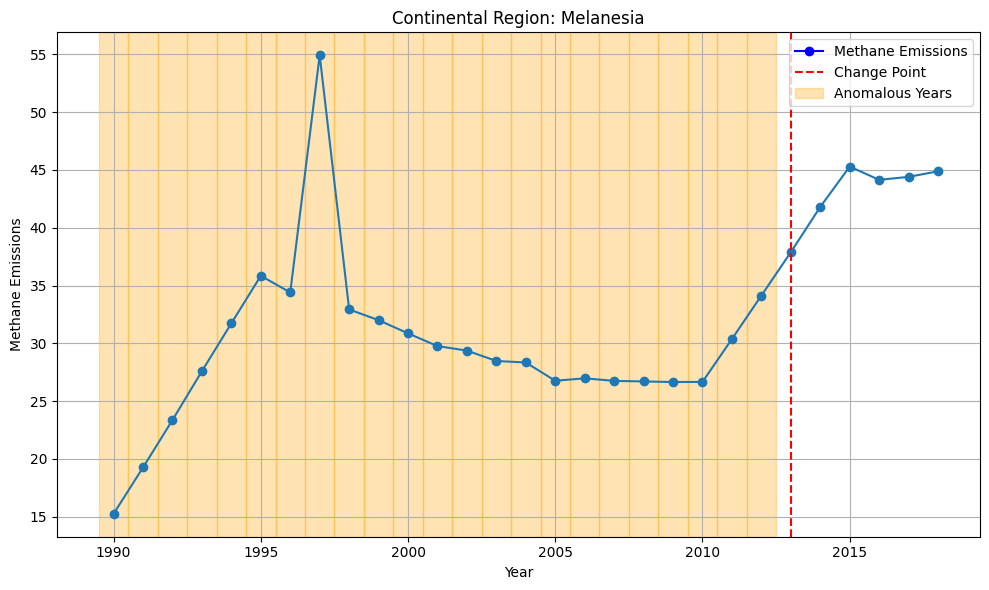

Region: Melanesia
  Observed LLR: 872.4335588455776
  Best Change Point Index: 23 (Year: 2013)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
  p-value from permutation testing: 0.002
  Number of Data Points: 29
------------------------------------------------------------


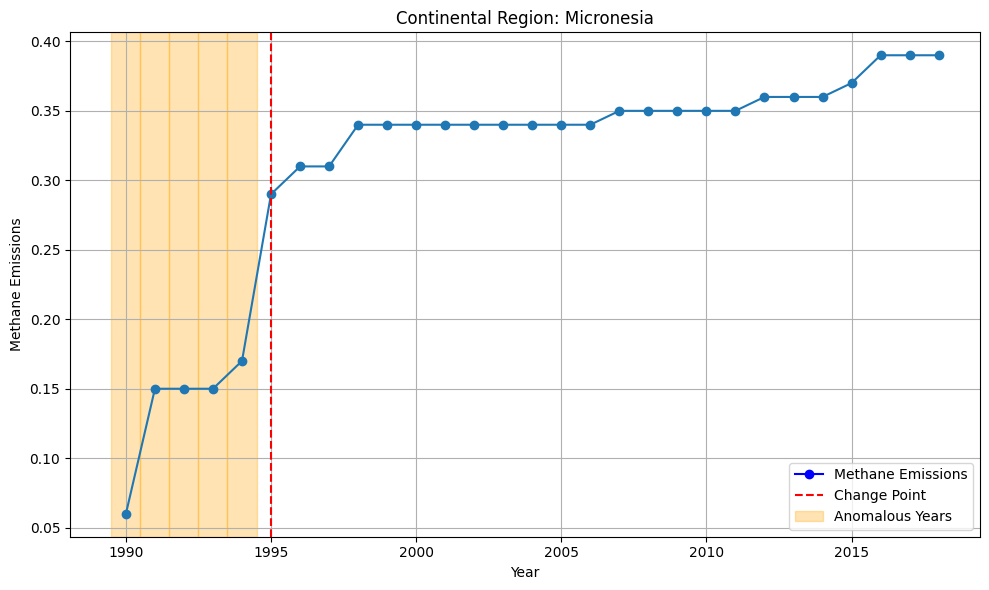

Region: Micronesia
  Observed LLR: 0.18509896551724142
  Best Change Point Index: 5 (Year: 1995)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


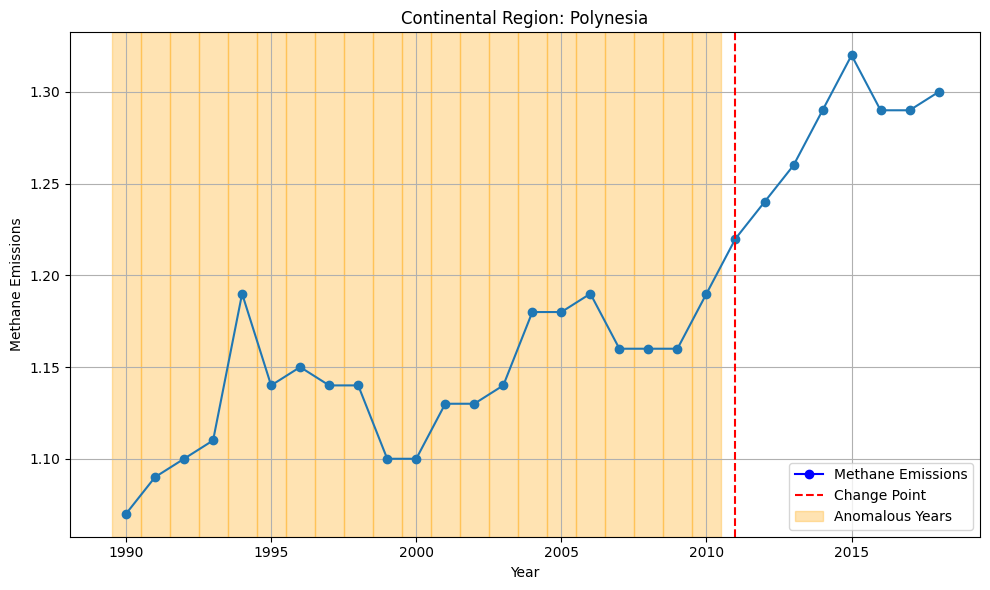

Region: Polynesia
  Observed LLR: 0.10679312397372742
  Best Change Point Index: 21 (Year: 2011)
  Anomalous Years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
  p-value from permutation testing: 0.0
  Number of Data Points: 29
------------------------------------------------------------


In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def visualize_country_anomalies(df, results, filtered_sorted_results):
    for region, res in filtered_sorted_results:
        group = df[df['sub-region'] == region].sort_values('year')
        years = group['year'].values
        emissions = group['value'].values

        plt.figure(figsize=(10, 6))
        plt.plot(years, emissions, marker='o', label='Methane Emissions')
        plt.axvline(x=res['best_year'], color='red', linestyle='--', label='Change Point')

        #highlight anomalous years
        for year in res['anomalous_years']:
            plt.axvspan(year - 0.5, year + 0.5, color='orange', alpha=0.3)

        #legend for anomalous years
        anomaly_patch = Patch(facecolor='orange', edgecolor='orange', alpha=0.3, label='Anomalous Years')

        plt.title(f"Continental Region: {region}")
        plt.xlabel("Year")
        plt.ylabel("Methane Emissions")
        plt.legend(handles=[plt.Line2D([0], [0], color='blue', marker='o', label='Methane Emissions'),
                            plt.Line2D([0], [0], color='red', linestyle='--', label='Change Point'),
                            anomaly_patch])
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        #print metadata
        print(f"Region: {region}")
        print(f"  Observed LLR: {res['observed_llr']}")
        print(f"  Best Change Point Index: {res['best_change_point_index']} (Year: {res['best_year']})")
        print(f"  Anomalous Years: {res['anomalous_years']}")
        print(f"  p-value from permutation testing: {res['p_value']}")
        print(f"  Number of Data Points: {res['n_points']}")
        print("-" * 60)

#run plots
visualize_country_anomalies(df, results, filtered_sorted_results)



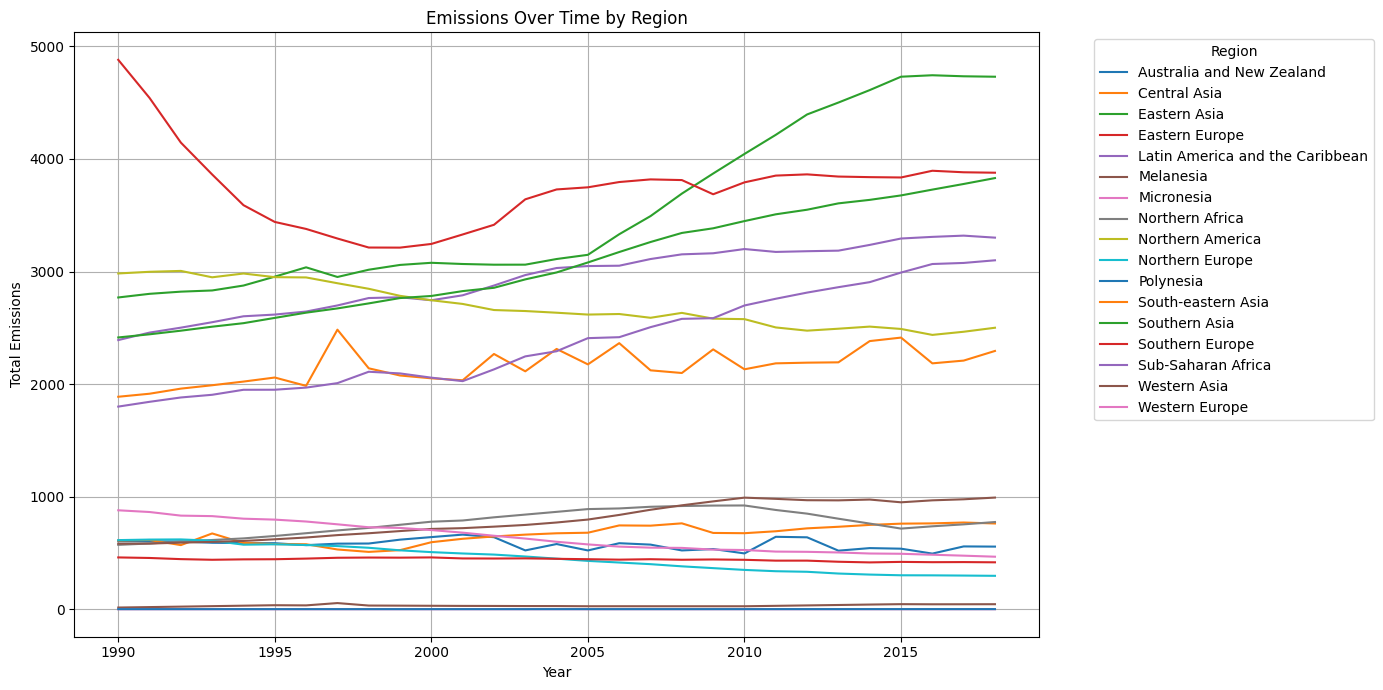

In [8]:
import matplotlib.pyplot as plt

def plot_emissions_by_region(df):
    # Group by sub-region and year, then compute total emissions
    region_yearly_emissions = df.groupby(['sub-region', 'year'])['value'].sum().reset_index()

    # Get list of unique sub-regions
    regions = region_yearly_emissions['sub-region'].unique()

    plt.figure(figsize=(14, 7))

    # Plot each region's emissions over time
    for region in regions:
        region_data = region_yearly_emissions[region_yearly_emissions['sub-region'] == region]
        plt.plot(region_data['year'], region_data['value'], label=region)

    plt.title("Emissions Over Time by Region")
    plt.xlabel("Year")
    plt.ylabel("Total Emissions")
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_emissions_by_region(df)
